See more information [here](https://mesa.readthedocs.io/latest/getting_started.html).

## First model

In [189]:
import mesa
import numpy as np
import pandas as pd
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid

In [62]:
class MyAgent(CellAgent):
    def __init__(self, model, age, cell=None):
        super().__init__(model)
        self.age = age
        self.cell = cell

    def step(self):
        self.age += 1
        print(f"Agent {self.unique_id} at {self.cell.coordinate} now is {self.age} years old")
        # Whatever else the agent does when activated

In [91]:
class MyModel(mesa.Model):
    def __init__(self, n_agents, seed=None):
        super().__init__(seed=seed)
        self.grid = OrthogonalMooreGrid((10, 10), torus=True, random=self.random)

        agents = MyAgent.create_agents(
            self,
            n_agents,
            cell=self.random.choices(self.grid.all_cells.cells, k=n_agents),
            age=self.rng.integers(0, 80, (n_agents,), endpoint=True),
        )

    def step(self):
        self.agents.do("step")

In [92]:
m1 = MyModel(n_agents=4, seed=15)

In [93]:
m1.step()

Agent 1 at (9, 6) now is 76 years old
Agent 2 at (0, 1) now is 57 years old
Agent 3 at (7, 3) now is 58 years old
Agent 4 at (1, 5) now is 67 years old


In [94]:
m1.step()

Agent 1 at (9, 6) now is 77 years old
Agent 2 at (0, 1) now is 58 years old
Agent 3 at (7, 3) now is 59 years old
Agent 4 at (1, 5) now is 68 years old


In [103]:
# Get total number of agents
num_agents = len(m1.agents)

# Iterate over all agents
print([agent.unique_id for agent in m1.agents])

[1, 2, 3, 4]


## Data collection

In [96]:
class MyModel(mesa.Model):
    def __init__(self, n_agents, seed=None):
        super().__init__(seed=seed)
        self.grid = OrthogonalMooreGrid((10, 10), torus=True, random=self.random)

        agents = MyAgent.create_agents(
            self,
            n_agents,
            cell=self.random.choices(self.grid.all_cells.cells, k=n_agents),
            age=self.rng.integers(0, 80, (n_agents,), endpoint=True),
        )
        
        self.datacollector = mesa.DataCollector(
            model_reporters={"mean_age": lambda m: m.agents.agg("age", np.mean)},
            agent_reporters={"age": "age"}
        )

    def step(self):
        self.agents.do("step")
        self.datacollector.collect(self)

In [97]:
m1 = MyModel(n_agents=4, seed=15)
for _ in range(3):
    m1.step()

Agent 1 at (9, 6) now is 76 years old
Agent 2 at (0, 1) now is 57 years old
Agent 3 at (7, 3) now is 58 years old
Agent 4 at (1, 5) now is 67 years old
Agent 1 at (9, 6) now is 77 years old
Agent 2 at (0, 1) now is 58 years old
Agent 3 at (7, 3) now is 59 years old
Agent 4 at (1, 5) now is 68 years old
Agent 1 at (9, 6) now is 78 years old
Agent 2 at (0, 1) now is 59 years old
Agent 3 at (7, 3) now is 60 years old
Agent 4 at (1, 5) now is 69 years old


In [98]:
m1.datacollector.get_model_vars_dataframe()

,mean_age
0,64.5
1,65.5
2,66.5


In [99]:
m1.datacollector.get_agent_vars_dataframe()

age
Step AgentID     
1    1         76
     2         57
     3         58
     4         67
2    1         77
     2         58
     3         59
     4         68
3    1         78
     2         59
     3         60
     4         69

## Add interaction between agents

In [176]:
class MyAgent(CellAgent):
    def __init__(self, model, age, cell=None):
        super().__init__(model)
        self.age = age
        self.cell = cell
        self.happiness = 0

    def _move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def _count_neighbors(self):
        return sum([len(c.agents) for c in self.cell.get_neighborhood(radius=2, include_center=False).cells])

    def step(self):
        self.age += 1

        n_neighbors = self._count_neighbors()
        if n_neighbors > 0:
            self.happiness += 1
        else:
            self.happiness -= 1
            self._move()

        print(f"Agent {self.unique_id} at {self.cell.coordinate} now is {self.age} years old with happiness score {self.happiness}")


In [177]:
class MyModel(mesa.Model):
    def __init__(self, n_agents=4, seed=None):
        super().__init__(seed=seed)
        self.grid = OrthogonalMooreGrid((10, 10), torus=True, random=self.random)

        agents = MyAgent.create_agents(
            self,
            n_agents,
            cell=self.random.choices(self.grid.all_cells.cells, k=n_agents),
            age=self.rng.integers(0, 80, (n_agents,), endpoint=True),
        )
        
        self.datacollector = mesa.DataCollector(
            model_reporters={"mean_age": lambda m: m.agents.agg("age", np.mean),
                             "mean_happiness": lambda m: m.agents.agg("happiness", np.mean)},
            agent_reporters={"age": "age", "happiness": "happiness"}
        )

    def step(self):
        self.agents.shuffle_do("step") # <---- randomize the order of the agent's actions ⚠️
        self.datacollector.collect(self)

In [178]:
m1 = MyModel(n_agents=2, seed=15)
for _ in range(5):
    m1.step()

Agent 2 at (9, 2) now is 57 years old with happiness score -1
Agent 1 at (9, 5) now is 76 years old with happiness score -1
Agent 2 at (8, 1) now is 58 years old with happiness score -2
Agent 1 at (8, 6) now is 77 years old with happiness score -2
Agent 1 at (8, 5) now is 78 years old with happiness score -3
Agent 2 at (7, 1) now is 59 years old with happiness score -3
Agent 1 at (9, 6) now is 79 years old with happiness score -4
Agent 2 at (8, 0) now is 60 years old with happiness score -4
Agent 1 at (0, 6) now is 80 years old with happiness score -5
Agent 2 at (8, 1) now is 61 years old with happiness score -5


## Visualize model

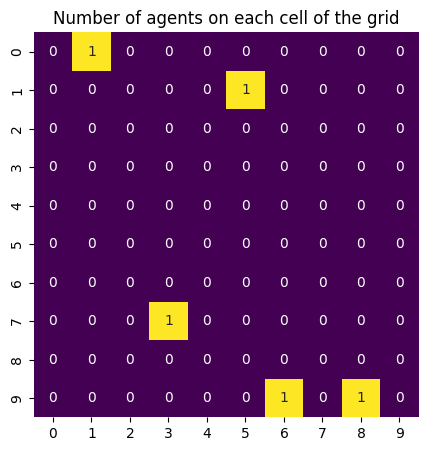

In [179]:
import seaborn as sns
m1 = MyModel(n_agents=5, seed=15)
agent_counts = np.zeros((m1.grid.width, m1.grid.height))

for cell in m1.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

### Dynamic visualization

In [227]:
class MyAgent(CellAgent):
    def __init__(self, model, age, cell=None):
        super().__init__(model)
        self.age = age
        self.cell = cell
        self.happiness = 0

    def _move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def _count_neighbors(self):
        return sum([len(c.agents) for c in self.cell.get_neighborhood(radius=2, include_center=False).cells])

    def step(self):
        self.age += 1

        n_neighbors = self._count_neighbors()
        random_number = self.random.random()
        if n_neighbors > 0:
            self.happiness += 1
            if random_number > 0.8:
                self._move()
        else:
            self.happiness -= 1
            if random_number > 0.2:
                self._move()


In [228]:
from mesa.visualization import SolaraViz, make_plot_component, make_space_component
def agent_portrayal(agent):
    return {
        "color": "tab:blue",
        "size": 50,
    }

model_params = {
    "n_agents": {
        "type": "SliderInt",
        "value": 4,
        "label": "Number of agents:",
        "min": 1,
        "max": 20,
        "step": 1,
    },
}

SpaceGraph = make_space_component(agent_portrayal)
HappinessPlot = make_plot_component("mean_happiness")

m2 = MyModel(n_agents=4, seed=15)

page = SolaraViz(
    m2,
    components=[SpaceGraph, HappinessPlot],
    model_params=model_params,
    name="My Model",
)
# This is required to render the visualization in the Jupyter notebook
page

Cannot show ipywidgets in text

## Model analysis

### Parameter sweep

In [229]:
results = mesa.batch_run(
    MyModel,
    parameters={"n_agents": list(range(2, 20))},
    iterations=10,
    max_steps=25,
    number_processes=1,
    data_collection_period=-1,  # Need to collect only at the last step
    display_progress=True,
)

results = pd.DataFrame(results)

  0%|          | 0/180 [00:00<?, ?it/s]

In [230]:
results.shape

(1890, 9)

In [231]:
results.head()

,RunId,iteration,Step,n_agents,mean_age,mean_happiness,AgentID,age,happiness
0,0,0,25,2,96.000000,-19.0,1,91,-17
1,0,0,25,2,96.000000,-19.0,2,99,-19
2,1,0,25,3,61.666667,-8.0,1,39,-19
3,1,0,25,3,61.666667,-8.0,2,72,-1
4,1,0,25,3,61.666667,-8.0,3,71,-1


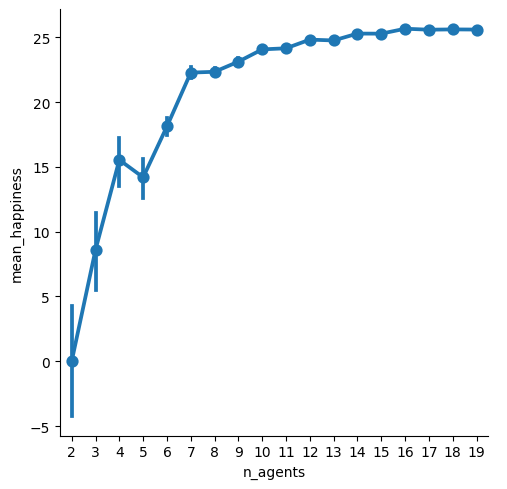

In [232]:
sns.catplot(
    results,
    x="n_agents",
    y="mean_happiness",
    kind="point"
)

In [233]:
results_100 = mesa.batch_run(
    MyModel,
    parameters={"n_agents": list(range(2, 20))},
    iterations=100,
    max_steps=25,
    number_processes=1,
    data_collection_period=-1,  # Need to collect only at the last step
    display_progress=True,
)

results_100 = pd.DataFrame(results_100)

  0%|          | 0/1800 [00:00<?, ?it/s]

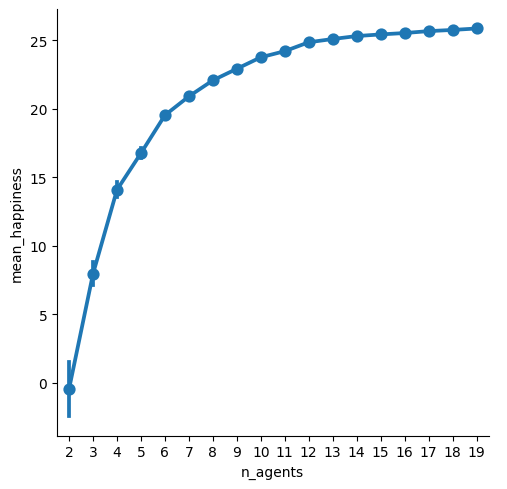

In [234]:
sns.catplot(
    results_100,
    x="n_agents",
    y="mean_happiness",
    kind="point"
);

### Timeseries visualization

In [235]:
results_ts = mesa.batch_run(
    MyModel,
    parameters={"n_agents": [2, 3, 6]},
    iterations=20,
    max_steps=200,
    number_processes=1,
    data_collection_period=1,  # Need to collect only at the last step
    display_progress=True,
)

results_ts = pd.DataFrame(results_ts)

  0%|          | 0/60 [00:00<?, ?it/s]

In [236]:
results_ts.shape

(44060, 9)

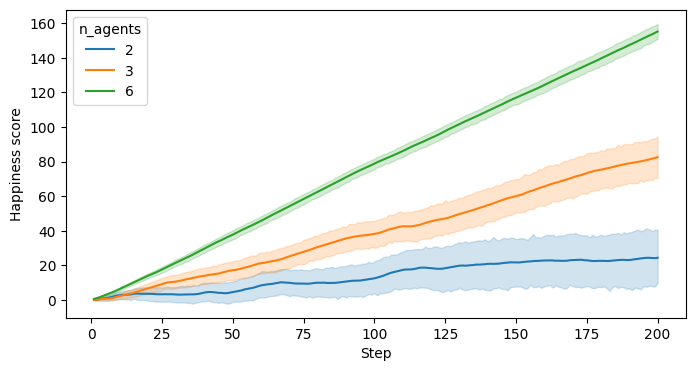

In [237]:
g = sns.lineplot(
    data=results_ts,
    x="Step",
    y="happiness",
    hue="n_agents",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)

g.set(ylabel="Happiness score");